### Optimized Code from Zach for SVR Plots

SVR

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import multiprocessing as mp
from itertools import product

def svr_update_progress_bar(completed, total, bar_length=50):
    progress = int(bar_length * completed / total)
    bar = '#' * progress + '_' * (bar_length - progress)
    print(f'[{bar}] {completed}/{total} iterations completed', end='\r')

def svr_process_combination(args):
    svr_sex, svr_C, svr_epsilon, svr_run, svr_target_feature, svr_X, svr_y, svr_num_splits = args
    svr_kf = KFold(n_splits=svr_num_splits, shuffle=True, random_state=svr_run)
    svr_model = make_pipeline(StandardScaler(), SVR(kernel='linear', C=svr_C, epsilon=svr_epsilon))
    svr_rmses = []

    for svr_train_index, svr_test_index in svr_kf.split(svr_X):
        svr_X_train, svr_X_test = svr_X.iloc[svr_train_index], svr_X.iloc[svr_test_index]
        svr_y_train, svr_y_test = svr_y.iloc[svr_train_index], svr_y.iloc[svr_test_index]
        
        svr_model.fit(svr_X_train, svr_y_train)
        svr_predictions = svr_model.predict(svr_X_test)
        svr_rmse = 100 * sqrt(mean_squared_error(svr_y_test, svr_predictions)) / np.sqrt(np.mean(np.square(svr_y_test)))
        svr_rmses.append(svr_rmse)
    
    return np.mean(svr_rmses)

if __name__ == '__main__':
    print("Loading data...")
    svr_train_df = pd.read_csv('./../Data/complete_data.csv')
    print("Data is loaded in, now running the model:")

    svr_sexes = ['Male', 'Female', 'All']
    svr_target_features = ["BMD - Total", "% fat - Total", "ALM"]

    svr_Cs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10, 50]
    svr_epsilons = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    svr_num_runs = 10
    svr_num_splits = 5

    svr_excluded_columns = ["0", "PPT ID", "Site", "Gender", "BMD - Total", "ALM", "% fat - Total", "Race"]

    svr_results_tensor = np.zeros((len(svr_sexes), len(svr_Cs), len(svr_epsilons), len(svr_target_features)), dtype=np.float64)

    svr_combinations = list(product(svr_sexes, svr_Cs, svr_epsilons, range(svr_num_runs), svr_target_features))
    svr_total_iterations = len(svr_combinations)

    with mp.Pool(processes=mp.cpu_count()) as svr_pool:
        svr_results = []
        for svr_i, (svr_sex, svr_C, svr_epsilon, svr_run, svr_target_feature) in enumerate(svr_combinations):
            svr_filtered_df = svr_train_df if svr_sex == 'All' else svr_train_df[svr_train_df['Gender'] == svr_sex]
            svr_X = svr_filtered_df.drop(columns=svr_excluded_columns)
            svr_y = svr_filtered_df[svr_target_feature]
            
            svr_result = svr_pool.apply_async(svr_process_combination, 
                                              ((svr_sex, svr_C, svr_epsilon, svr_run, svr_target_feature, svr_X, svr_y, svr_num_splits),))
            svr_results.append((svr_sex, svr_C, svr_epsilon, svr_target_feature, svr_result))
            
            svr_update_progress_bar(svr_i + 1, svr_total_iterations)

        for svr_sex, svr_C, svr_epsilon, svr_target_feature, svr_result in svr_results:
            svr_sex_idx = svr_sexes.index(svr_sex)
            svr_C_idx = svr_Cs.index(svr_C)
            svr_epsilon_idx = svr_epsilons.index(svr_epsilon)
            svr_target_feature_idx = svr_target_features.index(svr_target_feature)
            svr_results_tensor[svr_sex_idx, svr_C_idx, svr_epsilon_idx, svr_target_feature_idx] += svr_result.get() / svr_num_runs

    print('\nAll iterations completed.')


Loading data...
Data is loaded in, now running the model:
[##################################################] 12870/12870 iterations completed
All iterations completed.


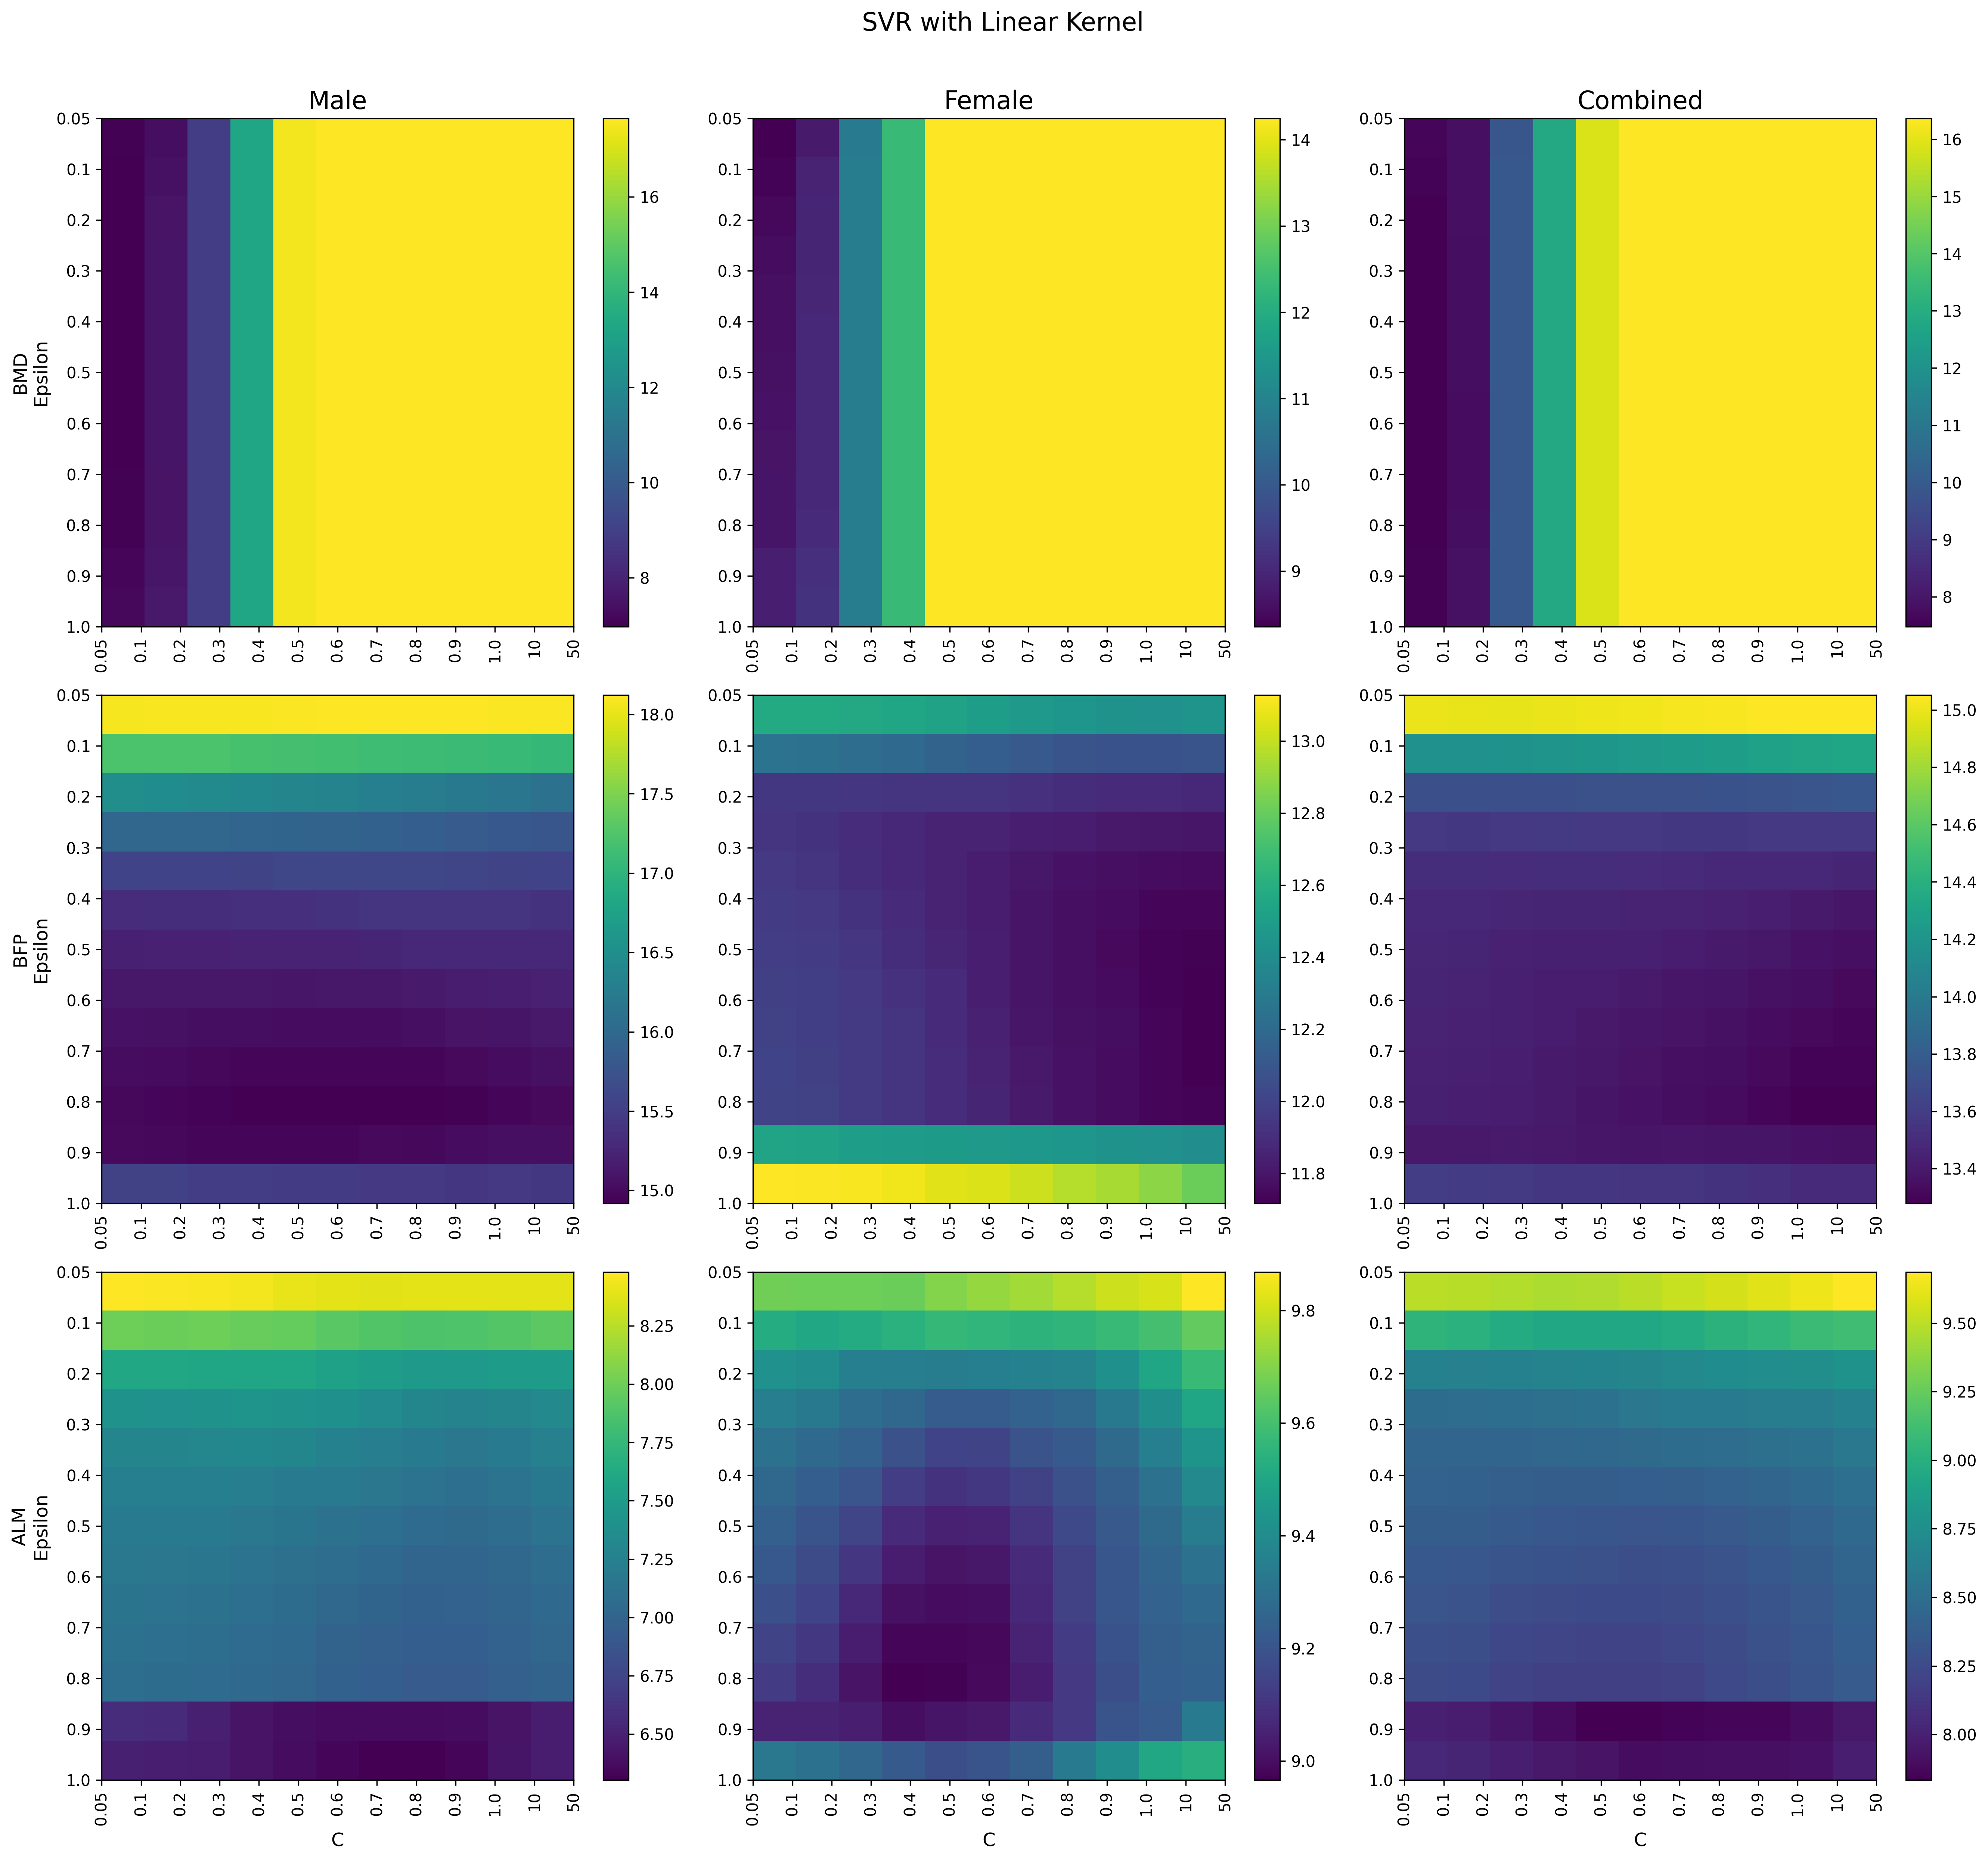

Best parameters for BMD - Total (Male):
  Epsilon: 0.05
  C: 0.2
  RMSE: 6.9699

Best parameters for BMD - Total (Female):
  Epsilon: 0.05
  C: 0.05
  RMSE: 8.3568

Best parameters for BMD - Total (All):
  Epsilon: 0.05
  C: 0.4
  RMSE: 7.4807

Best parameters for % fat - Total (Male):
  Epsilon: 0.5
  C: 1.0
  RMSE: 14.9181

Best parameters for % fat - Total (Female):
  Epsilon: 1.0
  C: 0.7
  RMSE: 11.7165

Best parameters for % fat - Total (All):
  Epsilon: 1.0
  C: 1.0
  RMSE: 13.2790

Best parameters for ALM (Male):
  Epsilon: 0.7
  C: 50
  RMSE: 6.3016

Best parameters for ALM (Female):
  Epsilon: 0.3
  C: 1.0
  RMSE: 8.9661

Best parameters for ALM (All):
  Epsilon: 0.4
  C: 10
  RMSE: 7.8337



In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure these match the order in your results tensor
svr_target_features = ["BMD - Total", "% fat - Total", "ALM"]
svr_sexes = ['Male', 'Female', 'All']
svr_row_titles = ['ALM', 'BFP', 'BMD']  # Order for display purposes
svr_column_titles = ['Male', 'Female', 'Combined']  # Display titles

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(18, 18), dpi=300)

# Map to correctly index the svr_results_tensor for the new row order
target_feature_map = {
    "ALM": 2,
    "% fat - Total": 1,
    "BMD - Total": 0
}

for i, svr_target in enumerate(["ALM", "% fat - Total", "BMD - Total"]):
    for j, svr_sex in enumerate(svr_sexes):
        ax = axes[i, j]
        
        # Extract the RMSE matrix for the current target and sex
        svr_rmse_matrix = svr_results_tensor[j, :, :, target_feature_map[svr_target]]
        
        # Plot the heatmap with correct orientation
        cax = ax.imshow(svr_rmse_matrix, cmap='viridis', aspect='auto', origin='upper',
                        extent=[0, len(svr_Cs)-1, 0, len(svr_epsilons)-1])
        
        # Set x-axis tick labels
        ax.set_xticks(range(len(svr_Cs)))
        ax.set_xticklabels(svr_Cs, rotation=90)
        
        # Set y-axis tick labels
        ax.set_yticks(range(len(svr_epsilons)))
        ax.set_yticklabels(svr_epsilons[::-1])  # Reverse the order
        
        # Set labels and titles
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
        if j == 0:
            ax.set_ylabel(f'{svr_row_titles[i]}\nEpsilon', fontsize=12)
        if i == 0:
            ax.set_title(svr_column_titles[j], fontsize=16)
        
        # Add colorbar
        fig.colorbar(cax, ax=ax)

plt.suptitle('SVR with Linear Kernel', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

# Find and print the best parameters
for svr_target_feature_idx, svr_target_feature in enumerate(["ALM", "% fat - Total", "BMD - Total"]):
    for svr_sex_idx, svr_sex in enumerate(svr_sexes):
        original_target_idx = target_feature_map[svr_target_feature]
        svr_best_idx = np.unravel_index(np.argmin(svr_results_tensor[svr_sex_idx, :, :, original_target_idx]),
                                        svr_results_tensor[svr_sex_idx, :, :, original_target_idx].shape)
        svr_best_C = svr_Cs[svr_best_idx[0]]
        svr_best_epsilon = svr_epsilons[svr_best_idx[1]]
        svr_best_rmse = svr_results_tensor[svr_sex_idx, svr_best_idx[0], svr_best_idx[1], original_target_idx]
        print(f"Best parameters for {svr_target_feature} ({svr_sex}):")
        print(f"  Epsilon: {svr_best_epsilon}")
        print(f"  C: {svr_best_C}")
        print(f"  RMSE: {svr_best_rmse:.4f}")
        print()


Nu(v)-SVR

In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import multiprocessing as mp
from itertools import product

def nusvr_update_progress_bar(completed, total, bar_length=50):
    progress = int(bar_length * completed / total)
    bar = '#' * progress + '_' * (bar_length - progress)
    print(f'[{bar}] {completed}/{total} iterations completed', end='\r')

def nusvr_process_combination(args):
    nusvr_sex, nusvr_C, nusvr_nu, nusvr_run, nusvr_target_feature, nusvr_X, nusvr_y, nusvr_num_splits = args
    nusvr_kf = KFold(n_splits=nusvr_num_splits, shuffle=True, random_state=nusvr_run)
    nusvr_model = make_pipeline(StandardScaler(), NuSVR(kernel='linear', C=nusvr_C, nu=nusvr_nu))
    nusvr_rmses = []

    for nusvr_train_index, nusvr_test_index in nusvr_kf.split(nusvr_X):
        nusvr_X_train, nusvr_X_test = nusvr_X.iloc[nusvr_train_index], nusvr_X.iloc[nusvr_test_index]
        nusvr_y_train, nusvr_y_test = nusvr_y.iloc[nusvr_train_index], nusvr_y.iloc[nusvr_test_index]
        
        nusvr_model.fit(nusvr_X_train, nusvr_y_train)
        nusvr_predictions = nusvr_model.predict(nusvr_X_test)
        nusvr_rmse = 100 * sqrt(mean_squared_error(nusvr_y_test, nusvr_predictions)) / np.sqrt(np.mean(np.square(nusvr_y_test)))
        nusvr_rmses.append(nusvr_rmse)
    
    return np.mean(nusvr_rmses)

if __name__ == '__main__':
    print("Loading data...")
    nusvr_train_df = pd.read_csv('./../Data/complete_data.csv')
    print("Data is loaded in, now running the model:")

    nusvr_sexes = ['Male', 'Female', 'All']
    nusvr_target_features = ["BMD - Total", "% fat - Total", "ALM"]

    nusvr_Cs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2, 5, 10, 25, 50, 75, 100, 125]
    nusvr_nus = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    nusvr_num_runs = 1#0
    nusvr_num_splits = 5

    nusvr_excluded_columns = ["0", "PPT ID", "Site", "Gender", "BMD - Total", "ALM", "% fat - Total", "Race"]

    nusvr_results_tensor = np.zeros((len(nusvr_sexes), len(nusvr_Cs), len(nusvr_nus), len(nusvr_target_features)))

    nusvr_combinations = list(product(nusvr_sexes, nusvr_Cs, nusvr_nus, range(nusvr_num_runs), nusvr_target_features))
    nusvr_total_iterations = len(nusvr_combinations)

    with mp.Pool(processes=mp.cpu_count()) as nusvr_pool:
        nusvr_results = []
        for nusvr_i, (nusvr_sex, nusvr_C, nusvr_nu, nusvr_run, nusvr_target_feature) in enumerate(nusvr_combinations):
            nusvr_filtered_df = nusvr_train_df if nusvr_sex == 'All' else nusvr_train_df[nusvr_train_df['Gender'] == nusvr_sex]
            nusvr_X = nusvr_filtered_df.drop(columns=nusvr_excluded_columns)
            nusvr_y = nusvr_filtered_df[nusvr_target_feature]
            
            nusvr_result = nusvr_pool.apply_async(nusvr_process_combination, 
                                                  ((nusvr_sex, nusvr_C, nusvr_nu, nusvr_run, nusvr_target_feature, nusvr_X, nusvr_y, nusvr_num_splits),))
            nusvr_results.append((nusvr_sex, nusvr_C, nusvr_nu, nusvr_target_feature, nusvr_result))
            
            nusvr_update_progress_bar(nusvr_i + 1, nusvr_total_iterations)

        for nusvr_sex, nusvr_C, nusvr_nu, nusvr_target_feature, nusvr_result in nusvr_results:
            nusvr_sex_idx = nusvr_sexes.index(nusvr_sex)
            nusvr_C_idx = nusvr_Cs.index(nusvr_C)
            nusvr_nu_idx = nusvr_nus.index(nusvr_nu)
            nusvr_target_feature_idx = nusvr_target_features.index(nusvr_target_feature)
            nusvr_results_tensor[nusvr_sex_idx, nusvr_C_idx, nusvr_nu_idx, nusvr_target_feature_idx] += nusvr_result.get() / nusvr_num_runs

    print('\nAll iterations completed.')

    


Loading data...
Data is loaded in, now running the model:


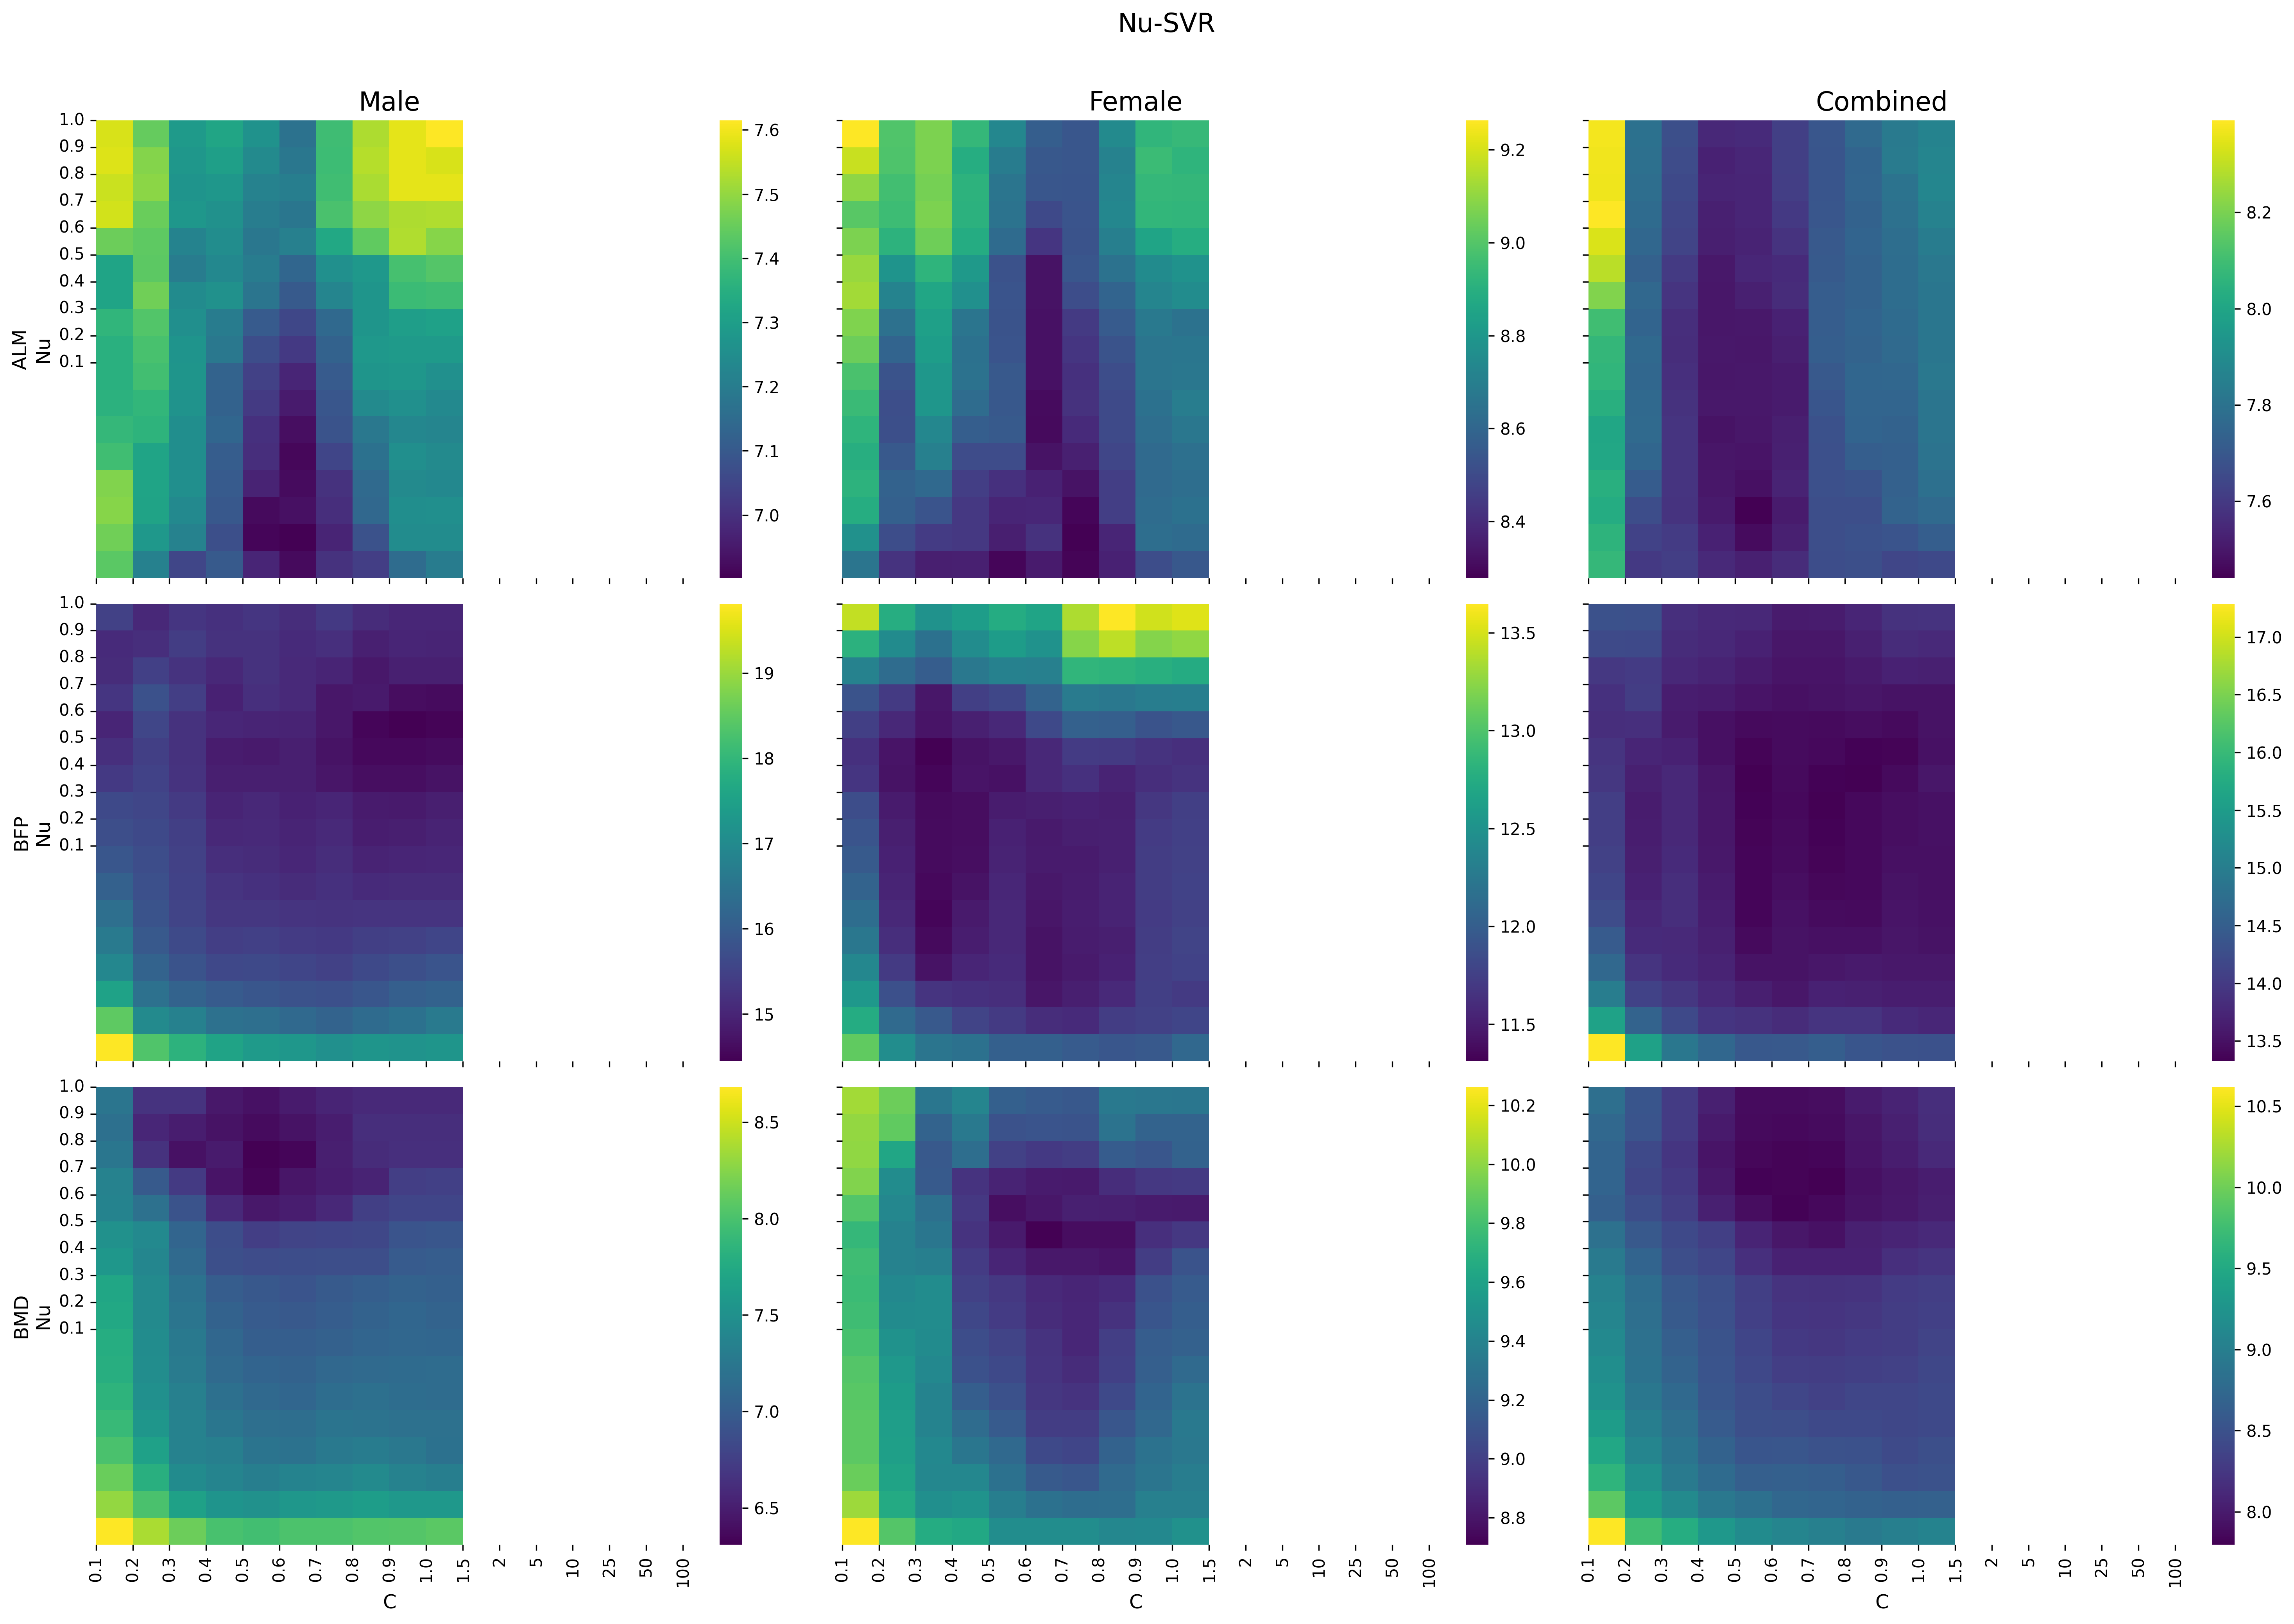

Best parameters for BMD - Total (Male):
  Nu: 0.6
  C: 0.2
  RMSE: 6.9020

Best parameters for BMD - Total (Female):
  Nu: 0.7
  C: 0.2
  RMSE: 8.2785

Best parameters for BMD - Total (Combined):
  Nu: 0.5
  C: 0.3
  RMSE: 7.4404

Best parameters for % fat - Total (Male):
  Nu: 0.9
  C: 5
  RMSE: 14.4432

Best parameters for % fat - Total (Female):
  Nu: 0.3
  C: 2
  RMSE: 11.3097

Best parameters for % fat - Total (Combined):
  Nu: 0.7
  C: 1.0
  RMSE: 13.3243

Best parameters for ALM (Male):
  Nu: 0.5
  C: 25
  RMSE: 6.3094

Best parameters for ALM (Female):
  Nu: 0.6
  C: 2
  RMSE: 8.7091

Best parameters for ALM (Combined):
  Nu: 0.7
  C: 10
  RMSE: 7.7985



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming nusvr_results_tensor, nusvr_target_features, nusvr_sexes, nusvr_Cs, and nusvr_nus are already defined
nusvr_sexes = ['Male', 'Female', 'Combined']  # Ensure the order is male, female, combined
nusvr_y_labels = ['ALM', 'BFP', 'BMD']  # Shortened labels

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(20, 12), dpi=300, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
nusvr_column_titles = ['Male', 'Female', 'Combined']
nusvr_row_titles = ['ALM', 'BFP', 'BMD']

for i, nusvr_target in enumerate(nusvr_target_features):
    for j, nusvr_sex in enumerate(nusvr_sexes):
        ax = axes[i, j]
        
        # Extract the RMSE matrix for the current target and sex
        nusvr_rmse_matrix = nusvr_results_tensor[j, :, :, i]
        
        # Reverse the rows of the RMSE matrix to align with the reversed y-axis
        nusvr_reversed_rmse_matrix = nusvr_rmse_matrix[::-1, :]
        
        # Plot the heatmap with the reversed data
        sns.heatmap(nusvr_reversed_rmse_matrix, ax=ax, cmap='viridis', cbar=True, cbar_kws={'shrink': 0.75}, xticklabels=nusvr_Cs, yticklabels=nusvr_nus[::-1])
        
        # Set x-axis tick labels only for the bottom row
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
            ax.set_xticks(range(len(nusvr_Cs)))
            ax.set_xticklabels(nusvr_Cs, rotation=90)
            ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
        else:
            ax.tick_params(axis='x', bottom=True, top=False, labelbottom=False, labeltop=False)
            ax.set_xticks(range(len(nusvr_Cs)))
        
        # Set y-axis tick labels only for the leftmost column
        if j == 0:
            ax.set_ylabel(f'{nusvr_row_titles[i]}\nNu', fontsize=12)
            ax.set_yticks(range(len(nusvr_nus)))
            
            # Reverse the nu values for the y-axis labels
            nusvr_nus_reversed = nusvr_nus[::-1]
            ax.set_yticklabels(nusvr_nus_reversed, rotation=0)
            ax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
        else:
            ax.tick_params(axis='y', left=True, right=False, labelleft=False, labelright=False)
            ax.set_yticks(range(len(nusvr_nus)))
        
        # Set column titles
        if i == 0:
            ax.set_title(nusvr_column_titles[j], fontsize=16)
        
plt.suptitle('Nu-SVR', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

# Find and print the best parameters
for nusvr_target_feature_idx, nusvr_target_feature in enumerate(nusvr_target_features):
    for nusvr_sex_idx, nusvr_sex in enumerate(nusvr_sexes):
        nusvr_best_idx = np.unravel_index(np.argmin(nusvr_results_tensor[nusvr_sex_idx, :, :, nusvr_target_feature_idx]), 
                                          nusvr_results_tensor[nusvr_sex_idx, :, :, nusvr_target_feature_idx].shape)
        nusvr_best_C = nusvr_Cs[nusvr_best_idx[0]]
        nusvr_best_nu = nusvr_nus[nusvr_best_idx[1]]
        nusvr_best_rmse = nusvr_results_tensor[nusvr_sex_idx, nusvr_best_idx[0], nusvr_best_idx[1], nusvr_target_feature_idx]
        print(f"Best parameters for {nusvr_target_feature} ({nusvr_sex}):")
        print(f"  Nu: {nusvr_best_nu}")
        print(f"  C: {nusvr_best_C}")
        print(f"  RMSE: {nusvr_best_rmse:.4f}")
        print()


LSSVR

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import multiprocessing as mp
from itertools import product
from lssvr import LSSVR

def lssvr_update_progress_bar(completed, total, bar_length=50):
    progress = int(bar_length * completed / total)
    bar = '#' * progress + '_' * (bar_length - progress)
    print(f'[{bar}] {completed}/{total} iterations completed', end='\r')

def lssvr_process_lssvr_combination(args):
    lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature, lssvr_X, lssvr_y, lssvr_num_splits = args
    lssvr_kf = KFold(n_splits=lssvr_num_splits, shuffle=True, random_state=lssvr_run)
    lssvr_rmses = []

    for lssvr_train_index, lssvr_test_index in lssvr_kf.split(lssvr_X):
        lssvr_X_train, lssvr_X_test = lssvr_X.iloc[lssvr_train_index], lssvr_X.iloc[lssvr_test_index]
        lssvr_y_train, lssvr_y_test = lssvr_y.iloc[lssvr_train_index], lssvr_y.iloc[lssvr_test_index]

        # Standardize features
        lssvr_scaler = StandardScaler()
        lssvr_X_train_scaled = lssvr_scaler.fit_transform(lssvr_X_train)
        lssvr_X_test_scaled = lssvr_scaler.transform(lssvr_X_test)

        # Ensure lssvr_y_train is a numpy array for proper indexing
        lssvr_y_train = lssvr_y_train.values

        lssvr_model = LSSVR(kernel='rbf', gamma=lssvr_gamma, C=lssvr_C)
        lssvr_model.fit(lssvr_X_train_scaled, lssvr_y_train)

        lssvr_predictions = lssvr_model.predict(lssvr_X_test_scaled)
        lssvr_rmse = 100 * sqrt(mean_squared_error(lssvr_y_test, lssvr_predictions)) / np.sqrt(np.mean(np.square(lssvr_y_test)))
        lssvr_rmses.append(lssvr_rmse)

    return np.mean(lssvr_rmses)

if __name__ == '__main__':
    print("Loading data...")
    lssvr_train_df = pd.read_csv('./../Data/complete_data.csv')
    print("Data is loaded in, now running the model:")

    lssvr_sexes = ['All', 'Male', 'Female']
    lssvr_target_features = ["ALM", "% fat - Total", "BMD - Total"]

    lssvr_gammas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
    # ^ gamma controls the influence of individual training samples(low valures are 'far' while high values are 'close')
    lssvr_Cs = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000, 10000]
    # ^ C regulization parameter controls the trade-off between achieving a low training error and a low testing error
    lssvr_num_runs = 10  # Increased for more robust results
    lssvr_num_splits = 5

    lssvr_excluded_columns = ["PPT ID", "Site", "Gender", "Race", "BMD - Total", "ALM", "% fat - Total"]

    lssvr_results_tensor = np.zeros((len(lssvr_sexes), len(lssvr_gammas), len(lssvr_Cs), len(lssvr_target_features)))

    lssvr_combinations = list(product(lssvr_sexes, lssvr_gammas, lssvr_Cs, range(lssvr_num_runs), lssvr_target_features))
    lssvr_total_iterations = len(lssvr_combinations)

    with mp.Pool(processes=mp.cpu_count()) as lssvr_pool:
        lssvr_results = []
        for lssvr_i, (lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature) in enumerate(lssvr_combinations):
            lssvr_filtered_df = lssvr_train_df if lssvr_sex == 'All' else lssvr_train_df[lssvr_train_df['Gender'] == lssvr_sex]
            lssvr_X = lssvr_filtered_df.drop(columns=lssvr_excluded_columns)
            lssvr_y = lssvr_filtered_df[lssvr_target_feature]
            
            lssvr_result = lssvr_pool.apply_async(lssvr_process_lssvr_combination, 
                                                  ((lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature, lssvr_X, lssvr_y, lssvr_num_splits),))
            lssvr_results.append((lssvr_sex, lssvr_gamma, lssvr_C, lssvr_target_feature, lssvr_result))
            
            lssvr_update_progress_bar(lssvr_i + 1, lssvr_total_iterations)

        for lssvr_sex, lssvr_gamma, lssvr_C, lssvr_target_feature, lssvr_result in lssvr_results:
            lssvr_sex_idx = lssvr_sexes.index(lssvr_sex)
            lssvr_gamma_idx = lssvr_gammas.index(lssvr_gamma)
            lssvr_C_idx = lssvr_Cs.index(lssvr_C)
            lssvr_target_feature_idx = lssvr_target_features.index(lssvr_target_feature)
            lssvr_results_tensor[lssvr_sex_idx, lssvr_gamma_idx, lssvr_C_idx, lssvr_target_feature_idx] += lssvr_result.get() / lssvr_num_runs

    print('\nAll iterations completed.')

Loading data...
Data is loaded in, now running the model:
[##################################################] 6480/6480 iterations completed
All iterations completed.


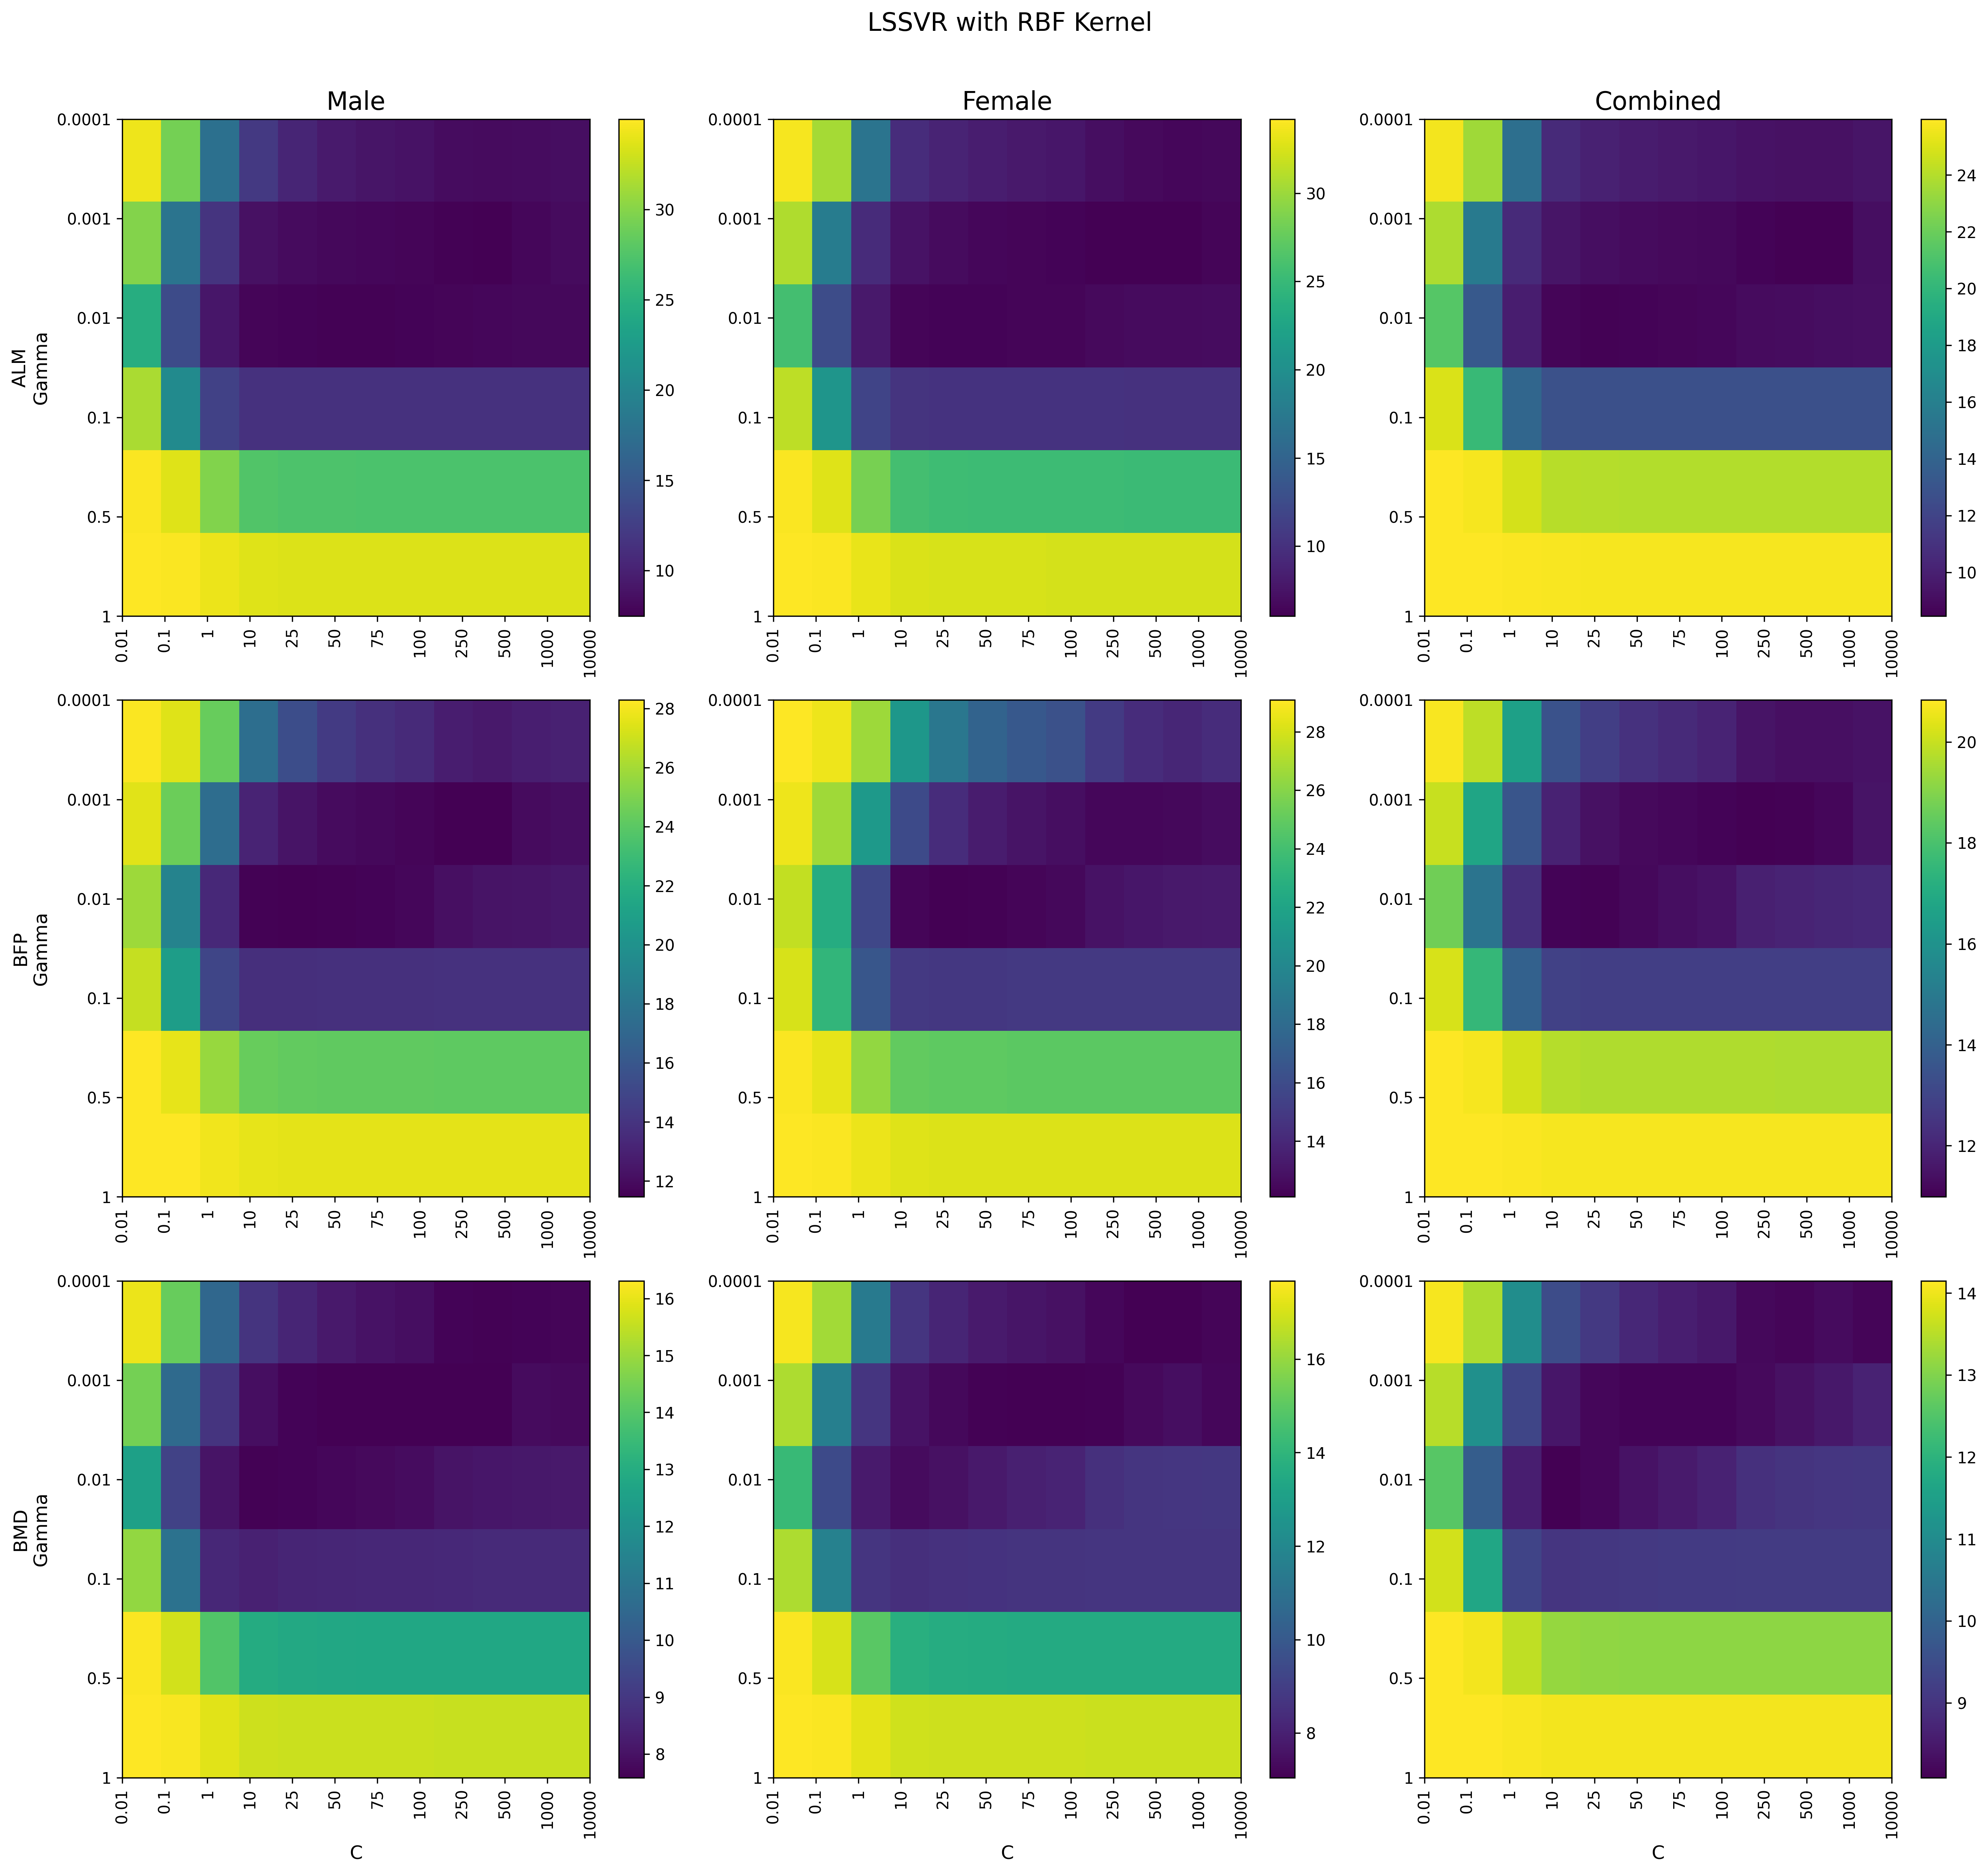

Best parameters for ALM (Male):
  Gamma: 0.001
  C: 500
  RMSE: 7.4697

Best parameters for ALM (Female):
  Gamma: 0.001
  C: 1000
  RMSE: 6.0332

Best parameters for ALM (All):
  Gamma: 0.001
  C: 1000
  RMSE: 8.4602

Best parameters for % fat - Total (Male):
  Gamma: 0.01
  C: 25
  RMSE: 11.4655

Best parameters for % fat - Total (Female):
  Gamma: 0.01
  C: 25
  RMSE: 12.0940

Best parameters for % fat - Total (All):
  Gamma: 0.001
  C: 250
  RMSE: 10.9861

Best parameters for BMD - Total (Male):
  Gamma: 0.001
  C: 250
  RMSE: 7.5873

Best parameters for BMD - Total (Female):
  Gamma: 0.001
  C: 100
  RMSE: 7.0485

Best parameters for BMD - Total (All):
  Gamma: 0.01
  C: 10
  RMSE: 8.0894



In [11]:
# Plotting the heatmaps
import matplotlib.pyplot as plt
import numpy as np

# Ensure these match the order in your results tensor
lssvr_target_features = ["ALM", "% fat - Total", "BMD - Total"]
lssvr_sexes = ['Male', 'Female', 'All']
lssvr_column_titles = ['Male', 'Female', 'Combined']  # Display titles as Male, Female, Combined
lssvr_row_titles = ['ALM', 'BFP', 'BMD']  # Order matches lssvr_target_features

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(18, 18), dpi=300)

for i, lssvr_target in enumerate(lssvr_target_features):
    for j, lssvr_sex in enumerate(lssvr_sexes):
        ax = axes[i, j]
        
        # Extract the RMSE matrix for the current target and sex
        lssvr_rmse_matrix = lssvr_results_tensor[lssvr_sexes.index(lssvr_sex), :, :, i]
        
        # Plot the heatmap with correct orientation
        cax = ax.imshow(lssvr_rmse_matrix, cmap='viridis', aspect='auto', origin='upper',
                        extent=[0, len(lssvr_Cs)-1, 0, len(lssvr_gammas)-1])
        
        # Set x-axis tick labels
        ax.set_xticks(range(len(lssvr_Cs)))
        ax.set_xticklabels(lssvr_Cs, rotation=90)
        
        # Set y-axis tick labels
        ax.set_yticks(range(len(lssvr_gammas)))
        ax.set_yticklabels(lssvr_gammas[::-1])  # Reverse the order
        
        # Set labels and titles
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
        if j == 0:
            ax.set_ylabel(f'{lssvr_row_titles[i]}\nGamma', fontsize=12)
        if i == 0:
            ax.set_title(lssvr_column_titles[j], fontsize=16)
        
        # Add colorbar
        fig.colorbar(cax, ax=ax)

plt.suptitle('LSSVR with RBF Kernel', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

# Find and print the best parameters
for lssvr_target_feature_idx, lssvr_target_feature in enumerate(lssvr_target_features):
    for lssvr_sex_idx, lssvr_sex in enumerate(lssvr_sexes):
        lssvr_best_idx = np.unravel_index(np.argmin(lssvr_results_tensor[lssvr_sex_idx, :, :, lssvr_target_feature_idx]),
                                          lssvr_results_tensor[lssvr_sex_idx, :, :, lssvr_target_feature_idx].shape)
        lssvr_best_gamma = lssvr_gammas[lssvr_best_idx[0]]
        lssvr_best_C = lssvr_Cs[lssvr_best_idx[1]]
        lssvr_best_rmse = lssvr_results_tensor[lssvr_sex_idx, lssvr_best_idx[0], lssvr_best_idx[1], lssvr_target_feature_idx]
        print(f"Best parameters for {lssvr_target_feature} ({lssvr_sex}):")
        print(f"  Gamma: {lssvr_best_gamma}")
        print(f"  C: {lssvr_best_C}")
        print(f"  RMSE: {lssvr_best_rmse:.4f}")
        print()
